In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay





In [25]:
df = pd.read_csv('/content/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:

df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [27]:
# Show missing values
print("Missing values before handling:\n", df.isnull().sum())

# Fill missing values
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Confirm missing values handled
print("Missing values after handling:\n", df.isnull().sum())


Missing values before handling:
 Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
Missing values after handling:
 Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [28]:
print("Duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("After removal, duplicate rows:", df.duplicated().sum())


Duplicate rows: 116
After removal, duplicate rows: 0


In [29]:
label_enc = LabelEncoder()
df['Sex'] = label_enc.fit_transform(df['Sex'])         # male=1, female=0
df['Embarked'] = label_enc.fit_transform(df['Embarked'])  # C=0, Q=1, S=2
df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [30]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


In [31]:
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)


In [32]:
#remove outliers
for col in ['Age', 'Fare']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

df.shape



(649, 10)

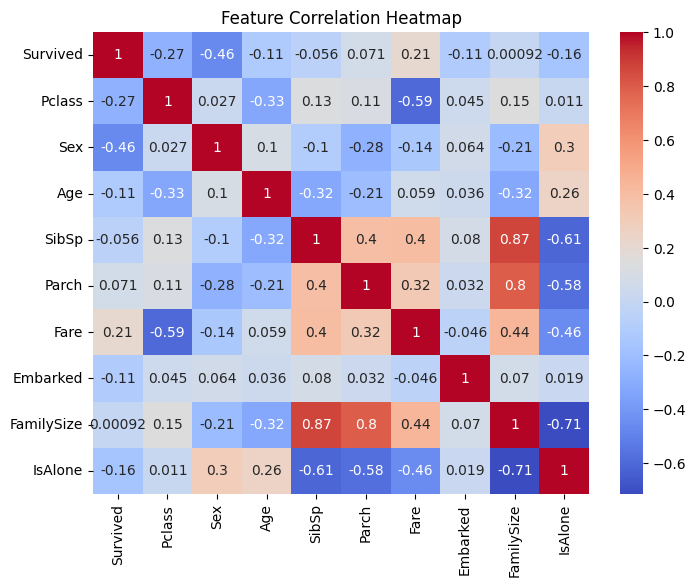

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [34]:
# Drop weak or irrelevant features based on correlation analysis
df = df.drop(['FamilySize', 'SibSp', 'Parch'], axis=1)


In [35]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [36]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
scaler = StandardScaler()
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])


In [38]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [39]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", round(train_acc, 4))
print("Test Accuracy:", round(test_acc, 4))



Train Accuracy: 0.7707
Test Accuracy: 0.7538


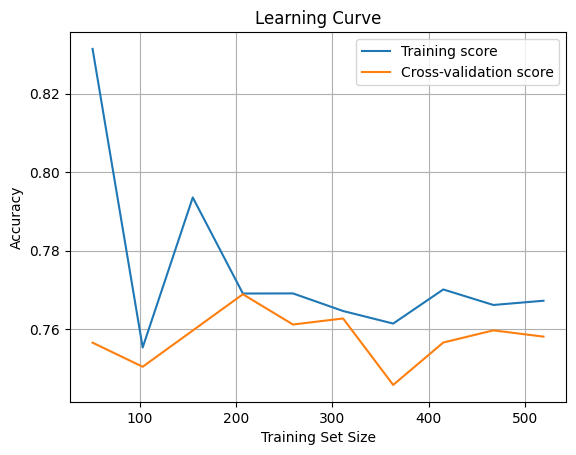

In [40]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()


In [41]:
# Correlation of all features with the target 'Survived'
cor_with_survived = df.corr()['Survived'].sort_values(ascending=False)
print(cor_with_survived)


Survived    1.000000
Fare        0.209169
Embarked   -0.107962
Age        -0.111712
IsAlone    -0.158092
Pclass     -0.267473
Sex        -0.459441
Name: Survived, dtype: float64


In [42]:
from sklearn.metrics import classification_report

# Predictions
y_test_pred = model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.78      0.80      0.79        74
           1       0.72      0.70      0.71        56

    accuracy                           0.75       130
   macro avg       0.75      0.75      0.75       130
weighted avg       0.75      0.75      0.75       130



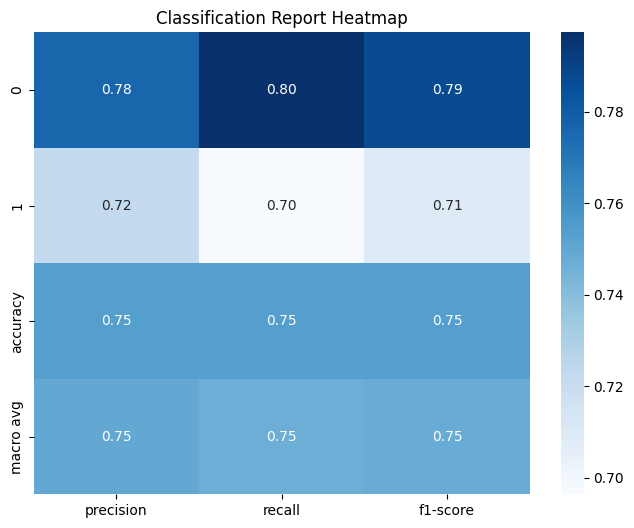

In [43]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get report as dictionary
report = classification_report(y_test, y_test_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


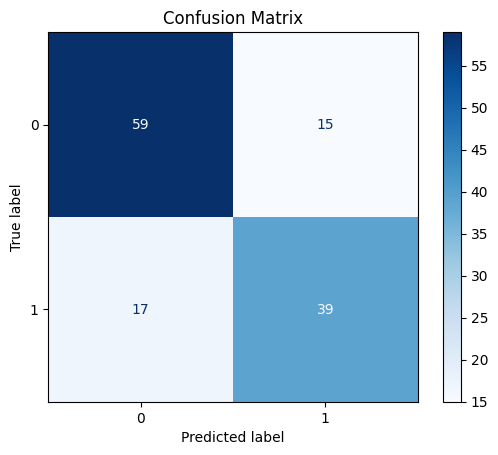

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



In [45]:
cor_with_survived = df.corr()['Survived'].sort_values(ascending=False)
print(cor_with_survived)


Survived    1.000000
Fare        0.209169
Embarked   -0.107962
Age        -0.111712
IsAlone    -0.158092
Pclass     -0.267473
Sex        -0.459441
Name: Survived, dtype: float64


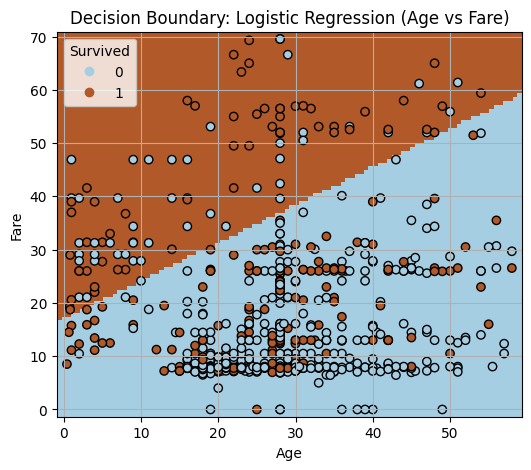

In [46]:
from sklearn.inspection import DecisionBoundaryDisplay

# Select 2 features (must be numeric and already scaled)
X_vis = X[['Age', 'Fare']].copy()
y_vis = y.copy()

# Fit a logistic regression on just those 2 features
logreg_vis = LogisticRegression()
logreg_vis.fit(X_vis, y_vis)

# Plot decision boundary
_, ax = plt.subplots(figsize=(6, 5))
disp = DecisionBoundaryDisplay.from_estimator(
    logreg_vis,
    X_vis,
    response_method="predict",
    plot_method="pcolormesh",
    cmap=plt.cm.Paired,
    ax=ax,
    shading="auto",
    xlabel="Age",
    ylabel="Fare",
)

# Plot data points
scatter = ax.scatter(X_vis['Age'], X_vis['Fare'], c=y_vis, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Decision Boundary: Logistic Regression (Age vs Fare)")
plt.legend(*scatter.legend_elements(), title="Survived")
plt.grid(True)
plt.show()
